In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from itertools import combinations
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap


In [2]:
from sklearn.metrics.cluster import davies_bouldin_score, silhouette_score

In [3]:
cluster_df = pd.read_csv('./data/cluster_Data.csv')

In [4]:
def scale_data(df: pd.DataFrame, scaler=MinMaxScaler, **kwargs):
    df = df.copy()
    scaler = scaler(**kwargs)
    column_names = df.columns
    scaled_data = scaler.fit_transform(df)
    new_df = pd.DataFrame(scaled_data, columns=column_names)
    return new_df

In [5]:
scaled_df = scale_data(cluster_df, StandardScaler)

Silhoutte Coeffecient

Bayesian Information Criterion

Elbow Rule

# TSNE

In [6]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random')
X_tsne_embedded = tsne.fit_transform(scaled_df.copy())

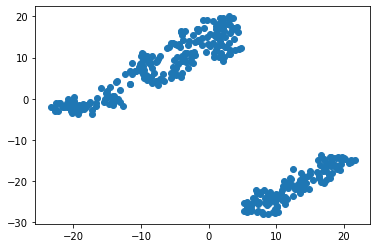

In [7]:
plt.scatter(X_tsne_embedded[:, 0], X_tsne_embedded[:, 1])

# UMAP

In [8]:
reducer = umap.UMAP(n_components=3)
X_umap_embedded = reducer.fit_transform(scaled_df.copy())
X_umap_embedded.shape

(342, 3)

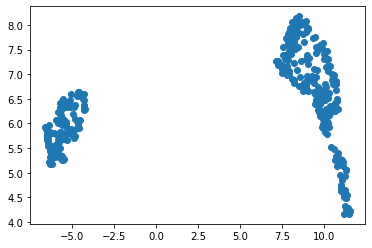

In [9]:
x, y = X_umap_embedded[:, 0], X_umap_embedded[:, 1]
plt.scatter(x, y)

# PCA

In [10]:
pca = PCA(n_components=2)
X_pca_embedded = pca.fit_transform(scaled_df.copy())

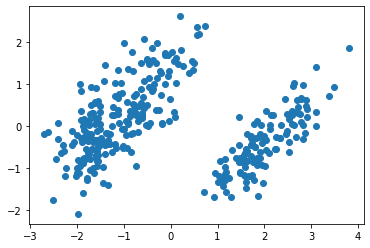

In [11]:
plt.scatter(X_pca_embedded[:, 0], X_pca_embedded[:, 1])

Silhoutte Coeffecient

In [20]:
models = []
X = scaled_df.copy()
cluster_range = list(range(2, 20))
for i in cluster_range:
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    models.append(kmeans)

In [21]:
# Elbow method
inertias = [model.inertia_ for model in models]
kn = KneeLocator(cluster_range, inertias, curve='convex', direction='decreasing')
print(f'The amount of clusters according to elbow method: {kn.knee}')

The amount of clusters according to elbow method: 6


In [14]:
# Silhoutte Coefficient
labels = [model.predict(X) for model in models]
silhouette_scores = [silhouette_score(X, label) for label in labels]


The amount of clusters according to silhouette coefficient: 2


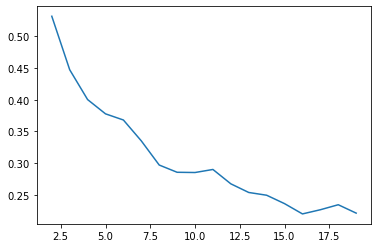

In [15]:
plt.plot(cluster_range, silhouette_scores)
score_clusters = list(zip(cluster_range, silhouette_scores))
score_clusters = sorted(score_clusters, key=lambda x: x[1], reverse=True)
print(f'The amount of clusters according to silhouette coefficient: {score_clusters[0][0]}')

In [16]:
# davies_bouldin_score
labels = [model.predict(X) for model in models]
db_scores = [davies_bouldin_score(X, label) for label in labels]

The amount of clusters according to silhouette coefficient: 2


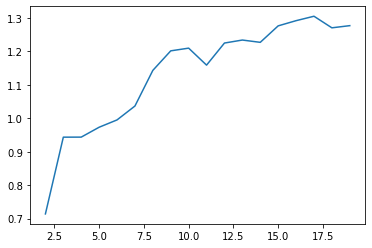

In [17]:
plt.plot(cluster_range, db_scores)
score_clusters = list(zip(cluster_range, db_scores))
score_clusters = sorted(score_clusters, key=lambda x: x[1], reverse=False)
print(f'The amount of clusters according to silhouette coefficient: {score_clusters[0][0]}')